# A factory for hybrid ground-truth generation


6/11/2018 Vidrio Technologies

## Preamble

Import a few modules.

In [1]:
import os
import sys
homedir = os.getenv("USERPROFILE") if sys.platform=='win32' else os.getenv("HOME")

import os.path as op

import matplotlib.pyplot as plt
import numpy as np

factory_dir = op.join(homedir, "repos", "hybridfactory")
if not factory_dir in sys.path:
    sys.path.insert(0, factory_dir)
    
import warnings
warnings.filterwarnings('ignore')

In [2]:
import factory.data.dataset
import factory.data.annotation
import factory.probes
import factory.validate.comparison

In [3]:
%matplotlib notebook

## Construct a probe

Use one of our helper functions...

<IPython.core.display.Javascript object>


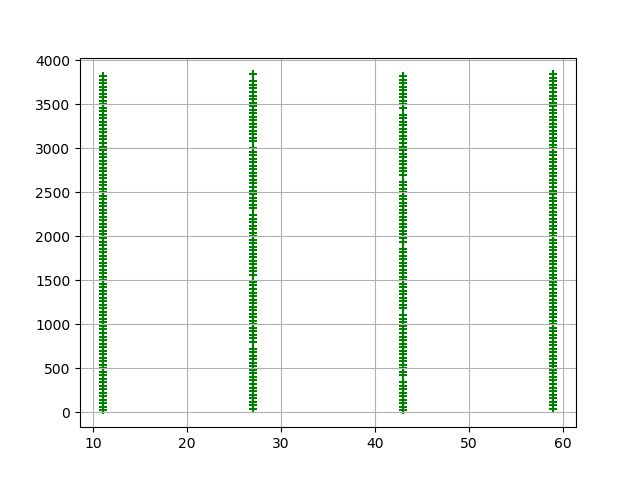

In [4]:
probe = factory.probes.neuropixels3a()  # synthetic eMouse probe from KiloSort
fig, ax = probe.display(label=False, marker='+', color='g')

... or roll your own:

In [5]:
channel_map = np.hstack((np.arange(64), np.array([111, 110, 109, 108, 106, 107, 104, 105, 102, 103, 100, 101, 98,
                                                  99, 96, 97, 80, 81, 82, 83, 85, 84, 87, 86, 89, 88, 91, 90, 93,
                                                  92, 95, 94, 65, 64, 67, 66, 69, 68, 71, 70, 73, 72, 75, 74, 76,
                                                  77, 78, 79, 126, 127, 124, 125, 122, 123, 120, 121, 118, 119, 116,
                                                  117, 115, 114, 113, 112]), np.arange(128, 256)))

# reference channels
refchans = np.hstack((np.arange(64), np.arange(128, 256)))
connected = ~np.isin(channel_map, refchans)

# physical location of each channel on the probe
xcoords = np.hstack((np.repeat(np.nan, 64),
                     np.repeat([0, 250], 32), np.repeat(np.nan, 128)))
ycoords = np.hstack((np.repeat(np.nan, 64),
                     np.tile(25 * np.arange(32), 2), np.repeat(np.nan, 128)))
channel_positions = np.hstack((xcoords[:, np.newaxis], ycoords[:, np.newaxis]))

custom = factory.probes.custom_probe(channel_map=channel_map, connected=connected, positions=channel_positions)

<IPython.core.display.Javascript object>


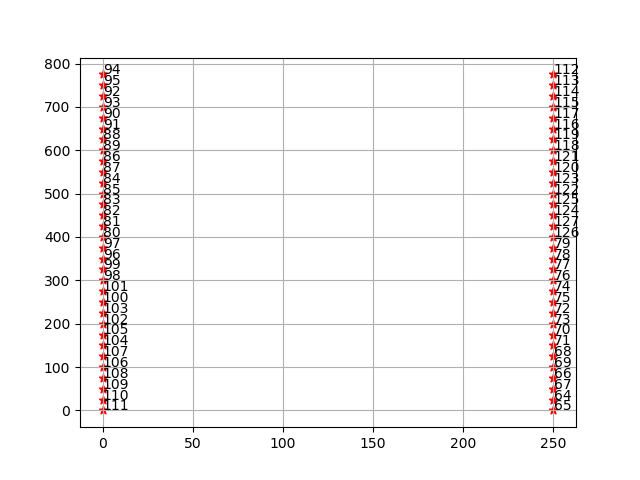

In [6]:
fig, ax = custom.display(marker='*', color='r')

## Load a data set with annotations

### Supported raw data formats
- SpikeGL\[X\]

### Supported annotation formats
- KiloSort (`rez.mat`)
- Phy (`*.npy`)
- JRCLUST (`*_jrc.mat`, `*_spk(raw|wav|fet).jrc`)

In [7]:
cortex_dir = r"F:\CortexLab\singlePhase3\data"
raw_file = op.join(cortex_dir, "Hopkins_20160722_g0_t0.imec.ap_CAR.bin")
output_type = "phy"

source = factory.data.dataset.new_annotated_dataset(raw_file, dtype=np.int16, sample_rate=30000, probe=probe)

## View and query annotations

In [8]:
source.annotations.head(10)

,timestep,cluster,template
0,135,1207,92
1,144,1195,64
2,154,1023,121
3,193,963,718
4,217,285,285
5,217,25,25
6,219,1023,121
7,224,308,308
8,236,1175,202
9,243,848,848


In [9]:
# how many events do we have in each cluster?
source.annotations.groupby("cluster").count().head(10)

,timestep,template
cluster,,
0,10083,10083
3,2570,2570
5,591,591
8,6022,6022
9,396,396
10,4,4
11,2285,2285
13,685,685
14,16139,16139


## Visualize units

In [13]:
k, unit = 10, 13  # select a cluster
t = source.annotations[source.annotations.cluster == unit].timestep.values[k]  # select a timestep

source.open_raw()  # open a memmap onto the raw data file
uw = source.unit_windows(unit, samples_before=30, samples_after=30)  # open windows onto all events in this cluster
region = uw[:, :, k]  # select one of these

<IPython.core.display.Javascript object>


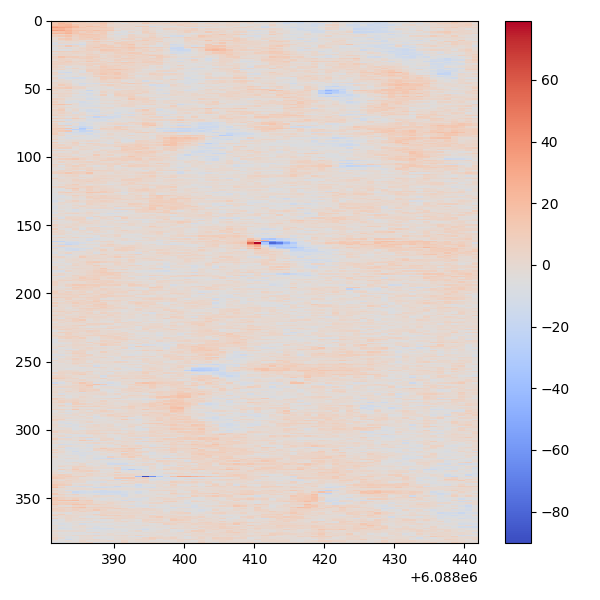

In [14]:
plt.figure(figsize=(5, 5))

plt.imshow(region, "coolwarm", aspect="auto", interpolation="nearest",
           extent=(t - 30, t + 31, probe.connected_channels().max(), 0))
plt.colorbar()
plt.tight_layout()

## Now construct a HybridDataSet from your source

In [15]:
hybrid = factory.data.dataset.new_hybrid_dataset(source=source,
                                                 output_directory=op.join(homedir, "Documents", "Data", "npix-hybrid"),
                                                 copy=False)